In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import math
import os
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt
from collections import Counter
import itertools
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, chi2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report, confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras import regularizers
import pathlib
import shutil
import tempfile

import tensorflow as tf
import re, string, nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer 
from nltk.tokenize import RegexpTokenizer

!pip install -q git+https://github.com/tensorflow/docs
    
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

import pathlib
import shutil
import tempfile

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
import tensorflow_hub as hub
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.8.2
Hub version:  0.12.0
GPU is available


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv("/content/drive/MyDrive/DL Assignment/archive.zip", compression='zip', encoding="ISO-8859-1", 
                 low_memory=False, 
                 header=None)

df.columns = ["target", "ids", "date", "flag", "user", "text"]
df.drop(["ids", "date", "flag", "user"], axis=1, inplace=True)
df = df.sample(frac=1) # Shuffling
df.head(7)

,target,text
804366,4,"@paulewatts She is very happy with the pc thanks, she can now watch time team online if she misses it!"
848751,4,"Mmmmmm. Tweetie is quite neat on the Mac, does what it says on the label. Will try it for a day or two."
1146164,4,Two hours ofwork left..then4 days off goig to see the fishies
208525,0,"Had worst night at work last night, worked 3 hours past shift thanks to asshole manager, phone died and locked out of store with no ride."
1351317,4,"Today is a beautiful day, let's spend it outside!"
1220930,4,"@amanda i'd be happy to send over a PDF portfolio if you want (I'm her agent, it seems just DM me your email"
512267,0,awww man~ i knew i forgot something. i forgot my camera for tonight's jap buffet spread dinner w friends!! wanna snap all the good food.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 804366 to 186191
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   text    1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 36.6+ MB


In [6]:
import tensorflow as tf
print("Num of GPUs available: ", len(tf.test.gpu_device_name()))

Num of GPUs available:  13


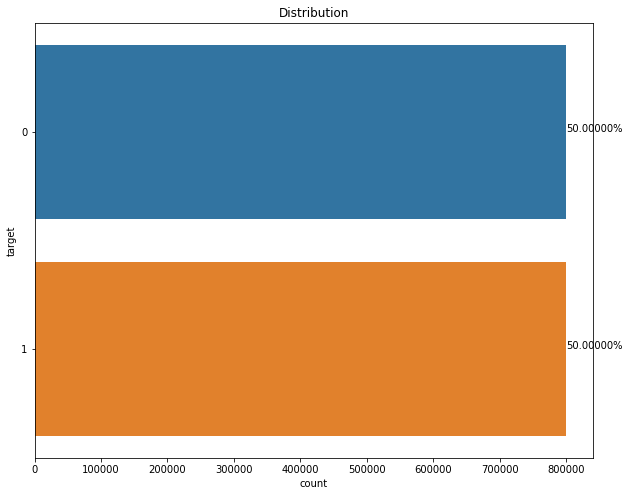

In [7]:
def value_count(df, col_name):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10,8))
    ax = sns.countplot(y = col_name, data=df, orient = 'v')

    plt.title('Distribution')

    total = len(df[col_name])
    for p in ax.patches:

        percentage = '{:.5f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

    plt.show()


df.loc[df["target"] == 4, "target"] = 1
value_count(df, "target") # Balanced class count for positive and negative

In [8]:
for target in df["target"].unique().tolist():
    tempDf = df[df["target"] == target].head(2)
    display(print(tempDf.to_markdown(tablefmt="grid")))
    print()

+--------+----------+---------------------------------------------------------------------------------------------------------+
|        |   target | text                                                                                                    |
+========+==========+=========================================================================================================+
| 804366 |        1 | @paulewatts She is very happy with the pc thanks, she can now watch time team online if she misses it!  |
+--------+----------+---------------------------------------------------------------------------------------------------------+
| 848751 |        1 | Mmmmmm. Tweetie is quite neat on the Mac, does what it says on the label. Will try it for a day or two. |
+--------+----------+---------------------------------------------------------------------------------------------------------+


None


+--------+----------+-------------------------------------------------------------------------------------------------------------------------------------------+
|        |   target | text                                                                                                                                      |
+========+==========+===========================================================================================================================================+
| 208525 |        0 | Had worst night at work last night, worked 3 hours past shift thanks to asshole manager, phone died and locked out of store with no ride. |
+--------+----------+-------------------------------------------------------------------------------------------------------------------------------------------+
| 512267 |        0 | awww man~ i knew i forgot something. i forgot my camera for tonight's jap buffet spread dinner w friends!!  wanna snap all the good food. |
+--------+----------+------

None

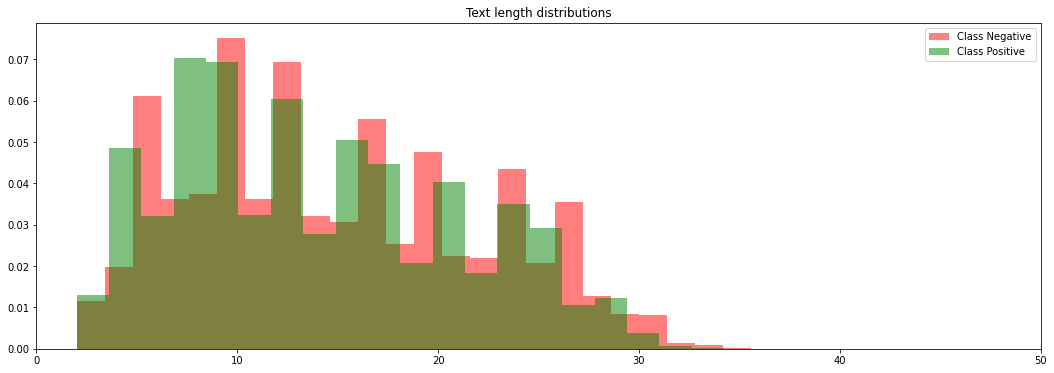

In [9]:
plt.figure(figsize=(18, 6))
lengths_0 = [len(t.split(' ')) for t in df[df["target"] == 0].text]
lengths_1 = [len(t.split(' ')) for t in df[df["target"] == 1].text]

plt.hist(lengths_0, bins = len(set(lengths_0)), density=True, alpha=0.5, color='r', label="Class Negative")
plt.hist(lengths_1, bins = len(set(lengths_1)), density=True, alpha=0.5, color='g', label="Class Positive")
plt.xlim(0, 50)
plt.title("Text length distributions")
plt.legend()
plt.show();

In [10]:
stopwords = stopwords.words('english')
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'\w+')

# Some basic helper functions to clean text by removing urls, emojis, html tags and punctuations.
def remove_stopwords(text):
    tokens = []
    
    for token in text.split():
        if token not in stop:
            tokens.append(token)
    return " ".join(tokens)


def remove_https(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_http(text):
    url = re.compile(r'http?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def remove_punctuations(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions

df['text'] = df['text'].astype(str).apply(lambda x: remove_stopwords(x))
df['text'] = df['text'].apply(lambda x: remove_http(x))
df['text'] = df['text'].apply(lambda x: remove_https(x))
df['text'] = df['text'].apply(lambda x: remove_html(x))
df['text'] = df['text'].apply(lambda x: remove_punctuations(x))
df.head(7)

,target,text
804366,1,paulewatts She happy pc thanks watch time team online misses it
848751,1,Mmmmmm Tweetie quite neat Mac says label Will try day two
1146164,1,Two hours ofwork leftthen4 days goig see fishies
208525,0,Had worst night work last night worked 3 hours past shift thanks asshole manager phone died locked store ride
1351317,1,Today beautiful day lets spend outside
1220930,1,amanda id happy send PDF portfolio want Im agent seems DM email
512267,0,awww man knew forgot something forgot camera tonights jap buffet spread dinner w friends wanna snap good food


In [11]:
df.isna().sum() # No na values

target    0
text      0
dtype: int64

In [12]:
def splitting(data, target, split_ratio):
    
    classes = np.unique(df.target) # Unique values for classes
    
    train_df, valid_df = train_test_split(df, train_size = split_ratio, stratify = df.target, random_state=42)

    return train_df, valid_df, classes

train_df, valid_df, classes = splitting(df, target="target", split_ratio = 0.75)

In [13]:
print("Shape of Train :", train_df.shape)
print("Shape of Test :", valid_df.shape)

Shape of Train : (1200000, 2)
Shape of Test : (400000, 2)


In [14]:
import tensorflow_hub as hub

# Text embedding based on feed-forward Neural-Net Language Models[1] with pre-built OOV. 
# Maps from text to 128-dimensional embedding vectors.

embed = hub.load("https://tfhub.dev/google/nnlm-en-dim128/2")



```
Neural-Net Language Model (NNLM): The model simultaneously learns representations of words and probability functions for word sequences, allowing it to capture semantics of a sentence. We will use a pretrained models available on Tensorflow Hub, that are trained on the English Google News 200B corpus, and computes a vector of 128 dimensions for the larger model and 50 dimensions for the smaller model.
```



In [15]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", input_shape=[], dtype=tf.string)
module_url = "https://tfhub.dev/google/nnlm-en-dim128/2"

In [16]:
!pip install -q git+https://github.com/tensorflow/docs
    
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [17]:
encoder = LabelEncoder() # https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class

# Computes the cross-entropy loss between true labels and predicted labels. 
# Use binarycrossentropy cross-entropy loss for binary (0 or 1) classification applications.

train_df['target'] = encoder.fit_transform(train_df['target'].tolist())
valid_df['target'] = encoder.transform(valid_df['target'].tolist())

In [18]:
valid_df['target'].value_counts()

0    200000
1    200000
Name: target, dtype: int64

#### We gradually decrease number of neurons in hidden layers by dividing the number of neurons in the previous layers by 2 in general. A more thorough discussion is provided in the [thread](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw). Since our input embedding is 128, the rest of the nodes should be decided in accordance to the suggested rules.

In [19]:
def train_and_evaluate_model(module_url, embed_size, name, trainable=False):
    
    hub_layer = hub.KerasLayer(module_url, input_shape = [], 
                               output_shape=[embed_size], 
                               dtype=tf.string, 
                               trainable=trainable)

    model = tf.keras.models.Sequential([
                                      hub_layer, # Input embedding layer
                                      tf.keras.layers.Dropout(0.4),
                                      tf.keras.layers.Dense(112, activation='relu', kernel_regularizer=regularizers.L2(0.01)),
                                      tf.keras.layers.Dropout(0.25),
                                      tf.keras.layers.Dense(96, activation='relu', kernel_regularizer=regularizers.L2(0.01)),
                                      tf.keras.layers.Dropout(0.25),
                                      tf.keras.layers.Dense(80, activation='relu', kernel_regularizer=regularizers.L2(0.01)),
                                      tf.keras.layers.Dropout(0.2),
                                      tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(0.01)),
                                      tf.keras.layers.Dropout(0.1),
                                      tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.L2(0.01)),
                                      tf.keras.layers.Dropout(0.1),
                                      tf.keras.layers.Dense(1, activation='sigmoid') # Binary class   
                                      ])
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001)
    
    # Compile the model with the appropriate loss function; Use accuracy as a metric.
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                  loss = tf.losses.BinaryCrossentropy(),
                  metrics=[tf.metrics.BinaryAccuracy(name='accuracy')])

    # Print the model summary.
    model.summary()

    history = model.fit(train_df['text'].values, train_df['target'], 
                      epochs=25, 
                      batch_size=512, 
                      validation_data=(valid_df['text'], valid_df['target']),
                      callbacks=[tfdocs.modeling.EpochDots(),
                                 tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                                  patience=5, 
                                                                  mode='min'),
                                 tf.keras.callbacks.TensorBoard(log_dir=logdir/name)],
                      verbose=1)
  
    return model, history

In [20]:
%%time 
""" To log the time taken for training"""

histories= {}

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
model, histories['nnlm-en-dim128/2'] = train_and_evaluate_model(module_url=module_url, 
                                             embed_size=128, 
                                             name='nnlm-en-dim128/2',
                                             trainable=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 112)               14448     
                                                                 
 dropout_1 (Dropout)         (None, 112)               0         
                                                                 
 dense_1 (Dense)             (None, 96)                10848     
                                                                 
 dropout_2 (Dropout)         (None, 96)                0         
                                                                 
 dense_2 (Dense)             (None, 80)                7

2344/2344 [==============================] - ETA: 0s - loss: 0.7119 - accuracy: 0.4997
Epoch: 0, accuracy:0.4997,  loss:0.7119,  val_accuracy:0.5000,  val_loss:0.6931,  
2344/2344 [==============================] - 63s 26ms/step - loss: 0.7119 - accuracy: 0.4997 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/25
2344/2344 [==============================] - 44s 19ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/25
2344/2344 [==============================] - 44s 19ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/25
2344/2344 [==============================] - 45s 19ms/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/25
2344/2344 [==============================] - 45s 19ms/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/25
2344/2344 [==============================] - 44s 19ms/step - loss: 0.6932 - accuracy: 0.4996 - val_l

In [21]:
def plotAccuracy(histories):
    plt.rcParams['figure.figsize'] = (12, 8)
    plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
    plotter.plot(histories)
    plt.xlabel("Epochs")
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
    plt.title("Accuracy Curves for Models")
    plt.show()

def plotLosses(histories):
    plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
    plotter.plot(histories)
    plt.xlabel("Epochs")
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
    plt.title("Loss Curves for Models")
    plt.show()

Print confusion matrix and classification report for the validation dataset. Analyse and report the best and worst performing class.

Example misclassified for class 0
Data : target    0                  
text      woke late zoo today
Name: 547295, dtype: object

Example misclassified for class 1
Data : target    1                                                    
text      sore showing old school skills diving board yesterday
Name: 1237824, dtype: object

Example misclassified for class 1
Data : target    1                        
text      sugarsharrk Thanks girlie
Name: 1099720, dtype: object

Example misclassified for class 0
Data : target    0                                                                                          
text      school tomorrow lameatleast taks withsummer needs comelike right nowso much look forward to
Name: 67327, dtype: object
Accuracy: 0.5
Precision: 0.0
Recall: 0.0
F1_score: 0.0

              precision    recall  f1-score   support

           0       0.50      1.00      0.67    200000
           1       0.00      0.00      0.00    200000

    accuracy                        

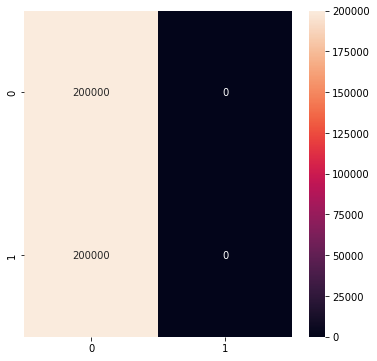

In [22]:
def modelValidator(validation, actuals, model):
    predictions = model.predict(validation)

   # Print the "two most" incorrectly classified records for each class in the test dataset.
    indices = []
    for idx, (actual, pred) in enumerate(zip(actuals, predictions)):
        indices.append((idx, actual, pred))

    indices.sort(key = lambda s:s[2], reverse=True)

    class_0, class_1 = 0, 0
    for count, values in enumerate(indices):
        if values[1] != values[2]:
            if values[1] == 0:
                if class_0 <= 2:
                    class_0 += 1
                    print(f"Example misclassified for class {values[1]}")
                    print("Data :", valid_df.iloc[count])
        else:
            if class_1 <= 2:
                class_1 += 1
                print(f"Example misclassified for class {values[1]}")
                print("Data :", valid_df.iloc[count])
    if class_0 == 2 and class_0 == 2:
        break;
    print()

    predictions = [1 if x > 0.5 else 0 for x in predictions] # Probabilities to class mapping.
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_matrix(actuals, predictions), annot = True, fmt='g')

    print(f"Accuracy: {round(accuracy_score(actuals, predictions), 2)}") 
    print(f"Precision: {round(precision_score(actuals, predictions), 2)}")
    print(f"Recall: {round(recall_score(actuals, predictions), 2)}")
    print(f"F1_score: {round(f1_score(actuals, predictions), 2)}")
    print()
    print(classification_report(actuals, predictions))

modelValidator(validation=valid_df['text'], actuals=valid_df['target'], model=model)

#### Hyperparameter Tuning

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 112)               14448     
                                                                 
 dropout_7 (Dropout)         (None, 112)               0         
                                                                 
 dense_7 (Dense)             (None, 96)                10848     
                                                                 
 dropout_8 (Dropout)         (None, 96)                0         
                                                                 
 dense_8 (Dense)             (None, 80)               

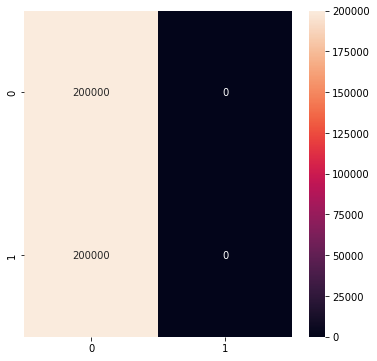

In [23]:
def noRegularizationModel(module_url, embed_size, name, trainable=False):
    
    hub_layer = hub.KerasLayer(module_url, input_shape = [], 
                               output_shape=[embed_size], 
                               dtype=tf.string, 
                               trainable=trainable)

    model = tf.keras.models.Sequential([
                                      hub_layer,
                                      tf.keras.layers.Dropout(0.4),
                                      tf.keras.layers.Dense(112, activation='relu'),
                                      tf.keras.layers.Dropout(0.25),
                                      tf.keras.layers.Dense(96, activation='relu'),
                                      tf.keras.layers.Dropout(0.25),
                                      tf.keras.layers.Dense(80, activation='relu'),
                                      tf.keras.layers.Dropout(0.2),
                                      tf.keras.layers.Dense(64, activation='relu'),
                                      tf.keras.layers.Dropout(0.1),
                                      tf.keras.layers.Dense(32, activation='relu'),
                                      tf.keras.layers.Dropout(0.1),
                                      tf.keras.layers.Dense(1, activation='sigmoid')            
                                      ])
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001)
    
    # Compile the model with the appropriate loss function; Use accuracy as a metric.
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                  loss = tf.losses.BinaryCrossentropy(),
                  metrics=[tf.metrics.BinaryAccuracy(name='accuracy')])

    # Print the model summary.
    model.summary()

    history = model.fit(train_df['text'].values, train_df['target'], 
                      epochs=25, 
                      batch_size=512, 
                      validation_data=(valid_df['text'], valid_df['target']),
                      callbacks=[tfdocs.modeling.EpochDots(),
                                 tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                                  patience=5, 
                                                                  mode='min')],
                      verbose=1)
  
    return model, history

noRegModel, histories['nnlm-en-dim128/2-NoRegularization'] = train_and_evaluate_model(module_url=module_url, 
                                             embed_size=128, 
                                             name='nnlm-en-dim128/2-NoRegularization',
                                             trainable=False)

modelValidator(validation=valid_df['text'], actuals=valid_df['target'], model=noRegModel)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_12 (Dense)            (None, 112)               14448     
                                                                 
 dense_13 (Dense)            (None, 96)                10848     
                                                                 
 dense_14 (Dense)            (None, 80)                7760      
                                                                 
 dense_15 (Dense)            (None, 64)                5184      
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 1)                

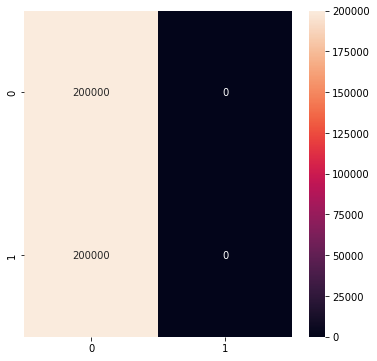

In [24]:
def noDropoutModel(module_url, embed_size, name, trainable=False):
    
    hub_layer = hub.KerasLayer(module_url, input_shape = [], 
                               output_shape=[embed_size], 
                               dtype=tf.string, 
                               trainable=trainable)
    
    model = tf.keras.models.Sequential([
                                      hub_layer, 
                                      tf.keras.layers.Dense(112, activation='relu', kernel_regularizer=regularizers.L2(0.01)),
                                      tf.keras.layers.Dense(96, activation='relu', kernel_regularizer=regularizers.L2(0.01)),
                                      tf.keras.layers.Dense(80, activation='relu', kernel_regularizer=regularizers.L2(0.01)),
                                      tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(0.01)),
                                      tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.L2(0.01)),
                                      tf.keras.layers.Dense(1, activation='sigmoid')             
                                      ])
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001)
    
    # Compile the model with the appropriate loss function; Use accuracy as a metric.
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005, clipvalue=0.5),
                  loss = tf.losses.BinaryCrossentropy(),
                  metrics=[tf.metrics.BinaryAccuracy(name='accuracy')])

    # Print the model summary.
    model.summary()

    history = model.fit(train_df['text'].values, train_df['target'], 
                      epochs=25, 
                      batch_size=512, 
                      validation_data=(valid_df['text'], valid_df['target']),
                      callbacks=[tfdocs.modeling.EpochDots(),
                                 tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                                  patience=5, 
                                                                  mode='min'),
                                 tf.keras.callbacks.TensorBoard(log_dir=logdir/name)],
                      verbose=1)
  
    return model, history


noDropoutModel, histories['nnlm-en-dim128/2-noDropout'] = noDropoutModel(module_url=module_url, 
                                             embed_size=128, 
                                             name='nnlm-en-dim128/2-noDropout',
                                             trainable=False)

modelValidator(validation=valid_df['text'], actuals=valid_df['target'], model=noDropoutModel)

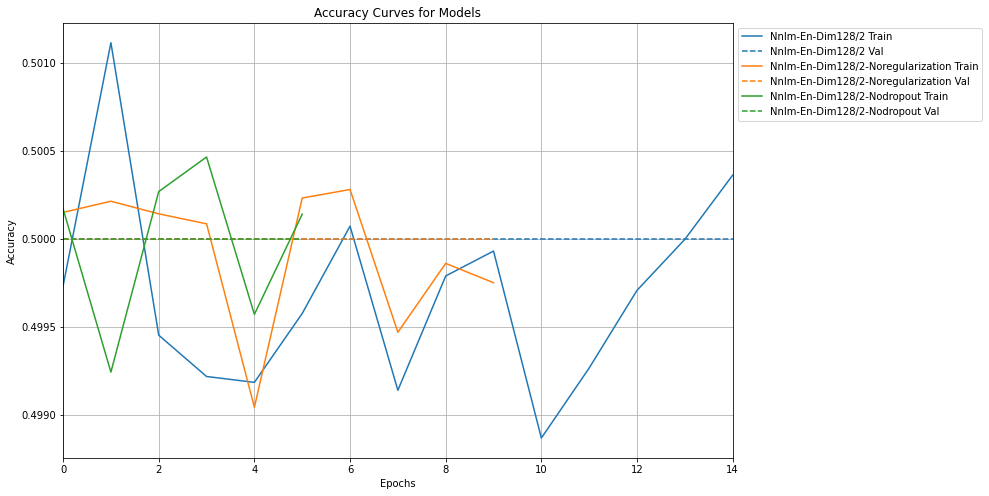

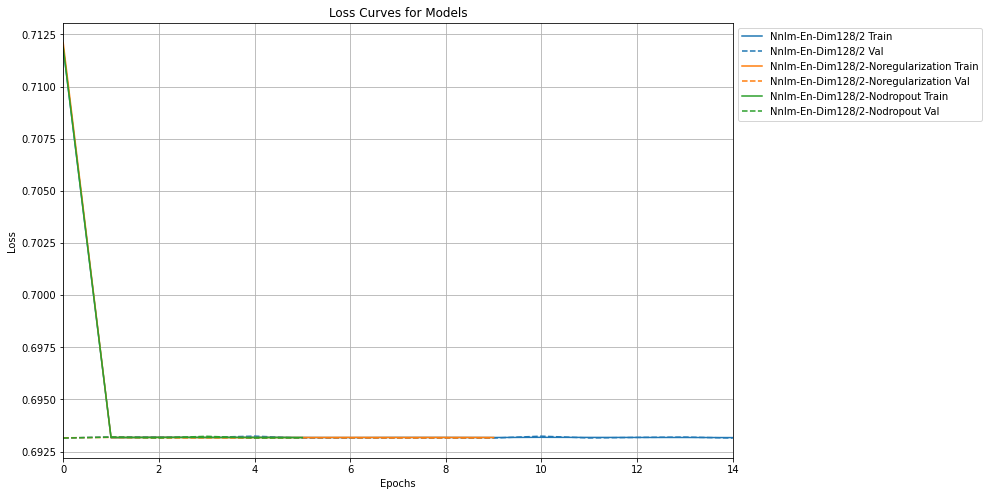

In [25]:
plotAccuracy(histories)
plotLosses(histories)

#### Observations:
- LSTM with tokenization & padding gives better results as compared to NNLM embeddings.
- Maybe because NNLM is Token based text embedding trained on English Google News 200B corpus which might be not reflective of the current dataset.
- An embedding created on the corpus of this data might have yielded better results than using pre-trained embedding.
- Adam & RmsProp both saturate after a while with no change in loss/accuracy & the callbacks ensure that the model stops training if no change happens.
- The model was unable to classify class "Positive".
- Given that the specified network architecture stated to keep "5" hidden layers, the model was unable to learn the underlying pattern.
- A smaller network architecture with 2 hidden layers yielded 17% better accuracy with both classes being classified.
- The loss function has a lot of fluctuations in a small range when it comes to the network with "No Dropouts added".
- Comparatively the model learnt significantly with both Regularization & drop-outs in place.
- Adam with learning_rate=0.005 was used, ideally the choice is to use ReduceLrOnPlateau in conjunction as a callback to ensure the model learns in a steep fashion w.r.t gradient changes.
- There was no vanishing gradient or explosion case seen.
- For text based embeddings, using ANN as compared to LSTM doesn't help much because it doesn't capture the temporal nature of the text component.